In [1]:
import pandas as pd
import numpy as np


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

In [5]:
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\keert\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
df = pd.read_csv("hsp_df_processed.csv")
print("Shape:", df.shape)
print(df.head())

Shape: (25000, 24)
   time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0                 8                72             1             18   
1                 3                34             2             13   
2                 5                45             0             18   
3                 2                36             0             12   
4                 1                42             0              7   

   n_outpatient  n_inpatient  n_emergency  medical_specialty  Circulatory  \
0             2            0            0                  4            1   
1             0            0            0                  5            0   
2             0            0            0                  4            1   
3             1            0            0                  4            1   
4             0            0            0                  3            1   

   Respiratory  ...  Musculoskeletal  glucose_test  HbA1ctest  med_change  \
0            1  ... 

In [8]:
target = "readmitted"
X = df.drop(columns=[target])
y = df[target]

In [13]:
cat_cols = ["medical_specialty", "med_change", "diabetes_med", "age_cat", "severity"]


In [14]:
print(df.columns.tolist())


['time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency', 'medical_specialty', 'Circulatory', 'Respiratory', 'Other', 'Diabetes', 'Injury', 'Digestive', 'Musculoskeletal', 'glucose_test', 'HbA1ctest', 'med_change', 'diabetes_med', 'readmitted', 'age_cat', 'total_visits', 'high_risk', 'severity']


In [15]:
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [17]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("After SMOTE:", X_train_bal.shape, y_train_bal.value_counts())

After SMOTE: (21194, 23) readmitted
0    10597
1    10597
Name: count, dtype: int64


In [18]:
print("Training Logistic Regression...")
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train_bal, y_train_bal)

Training Logistic Regression...


C:\Users\keert\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


In [19]:
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_bal, y_train_bal)

Training Random Forest...


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
print("Training LightGBM...")
lgb_train = lgb.Dataset(X_train_bal, y_train_bal)
params = {
'objective': 'binary',
'metric': 'auc',
'verbosity': -1,
'learning_rate': 0.05,
'num_leaves': 31,
'feature_fraction': 0.8,
'bagging_fraction': 0.8,
'bagging_freq': 5,
'seed': 42
}
model_lgb = lgb.train(params, lgb_train, num_boost_round=200)

Training LightGBM...


In [21]:
log_pred = log_reg.predict_proba(X_test)[:,1]
rf_pred = rf.predict_proba(X_test)[:,1]
lgb_pred = model_lgb.predict(X_test)

In [22]:
ensemble_pred = (log_pred + rf_pred + lgb_pred) / 3

In [23]:
print("=== Evaluation ===")
acc = accuracy_score(y_test, (ensemble_pred>0.5).astype(int))
auc = roc_auc_score(y_test, ensemble_pred)
print("Accuracy:", acc)
print("AUC:", auc)
print("Classification Report:\n", classification_report(y_test, (ensemble_pred>0.5).astype(int)))

=== Evaluation ===
Accuracy: 0.61
AUC: 0.6499933604151322
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.66      0.64      2649
           1       0.59      0.55      0.57      2351

    accuracy                           0.61      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.61      0.61      0.61      5000



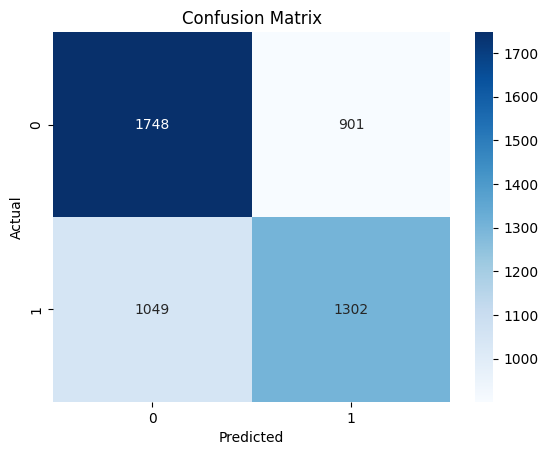

In [24]:
cm = confusion_matrix(y_test, (ensemble_pred>0.5).astype(int))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

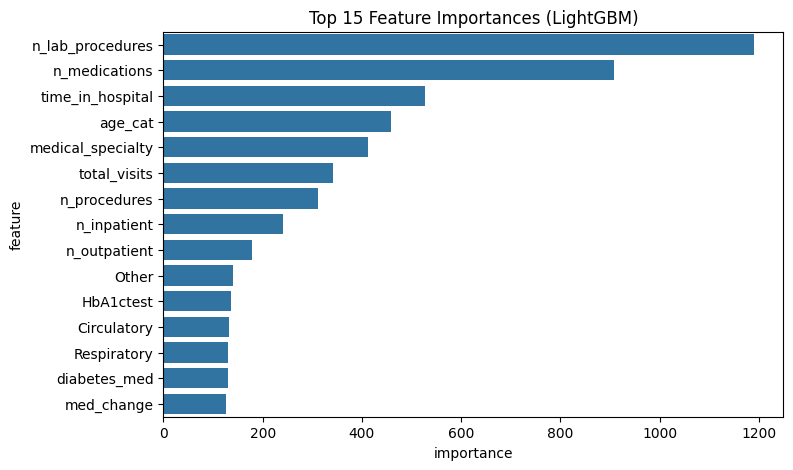

In [25]:
importance = model_lgb.feature_importance()
feat_imp = pd.DataFrame({"feature": X.columns, "importance": importance})
feat_imp = feat_imp.sort_values(by="importance", ascending=False)


plt.figure(figsize=(8,5))
sns.barplot(x="importance", y="feature", data=feat_imp.head(15))
plt.title("Top 15 Feature Importances (LightGBM)")
plt.show()

C:\Users\keert\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


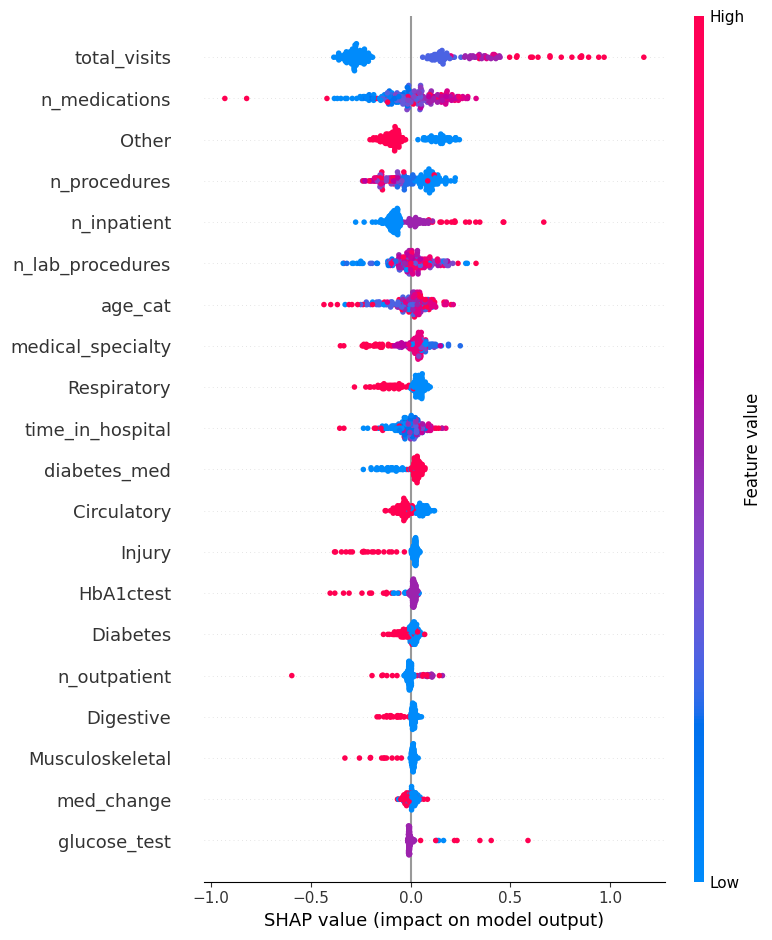

In [26]:
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X_test[:200]) # sample 200 for speed


shap.summary_plot(shap_values, X_test[:200], feature_names=X.columns)